In [1]:
from data.image_pair_dataset import Paired_Dataset
from torchvision.transforms import transforms


data_dirs = ['./training_data/DIV2K_train_HR', './training_data/Flickr2K']
data = Paired_Dataset(image_directories=data_dirs, scale=2, patch_size=(500, 500))

hr, lr = data[470]
print(hr.shape, lr.shape)

to_pil = transforms.ToPILImage()

to_pil(hr).show()
to_pil(lr).show()

torch.Size([3, 1000, 1000]) torch.Size([3, 500, 500])


In [2]:
from data.get_loader import get_loader
from torchvision.transforms import transforms

data_dirs = ['./training_data/DIV2K_train_HR', './training_data/Flickr2K']
prefetcher = get_loader(image_directories=data_dirs,
                        scale=4,
                        patch_size=(100, 100),
                        batch_size=1,
                        device=None,
                        num_workers=2,
                        pin_memory=False)


batch = prefetcher.next()
lr, hr = batch
print(lr.shape, hr.shape)
lr = lr.squeeze(0)
hr = hr.squeeze(0)
print(lr.shape, hr.shape)

to_pil = transforms.ToPILImage()

to_pil(hr).show()
to_pil(lr).show()

torch.Size([1, 3, 100, 100]) torch.Size([1, 3, 400, 400])
torch.Size([3, 100, 100]) torch.Size([3, 400, 400])


In [2]:
# from train.trainer import Trainer

# trainer = Trainer('train_yamls/RWVKSR_2X.yaml')
# # trainer.train()

In [26]:
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

img = Image.open('training_data/test.png').convert('RGB')
img = transforms.ToTensor()(img).unsqueeze(0)
# pooled = nn.AvgPool2d(4)(img)
pooled = TF.gaussian_blur(img, kernel_size=49, sigma=1.5)
pooled = nn.Upsample(size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False)(pooled)

hfd = img - pooled
# hfd = hfd.clamp(0, 1)
hfd = transforms.ToPILImage()(hfd.squeeze(0))
hfd.show()




In [2]:
import torch

model_file = torch.load('checkpoints/2X_RWKV6_9SR/iteration_500000.pt', map_location='cpu')
state_dict = model_file['model_state_dict']

total_params = sum(param.numel() for param in state_dict.values())

print(f"number of model parameters: {total_params/1e6}M")
print(f"{'name':90s} {'mean':>12s} {'std':>12s} {'min':>12s} {'max':>12s}")
for name, t in state_dict.items():
    # if 'high_pass_weight' in name:
    # if 'gamma' in name:
            print(f'{name:90s} {t.mean():>12f} {t.std():>12f} {t.min():>12f} {t.max():>12f}')


number of model parameters: 0.385235M
name                                                                                               mean          std          min          max
conv_first.weight                                                                             -0.001544     0.149126    -0.690508     0.749951
conv_first.bias                                                                               -0.080022     0.231331    -0.452786     0.395218
patch_embed.norm.weight                                                                        1.048107     0.166963     0.650799     1.574347
patch_embed.norm.bias                                                                          0.061195     0.140527    -0.245104     0.434764
layers.0.conv1.net.0.weight                                                                    0.002246     0.146377    -0.878663     1.074870
layers.0.conv1.net.0.bias                                                                      0.028276 

C:\Users\farns\AppData\Local\Temp\ipykernel_15040\747484817.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_file = torch.load('checkpoints/2X_RWKV6_9SR/iteration_5

C:\Users\farns\AppData\Local\Temp\ipykernel_15040\2686800342.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_file = torch.load(


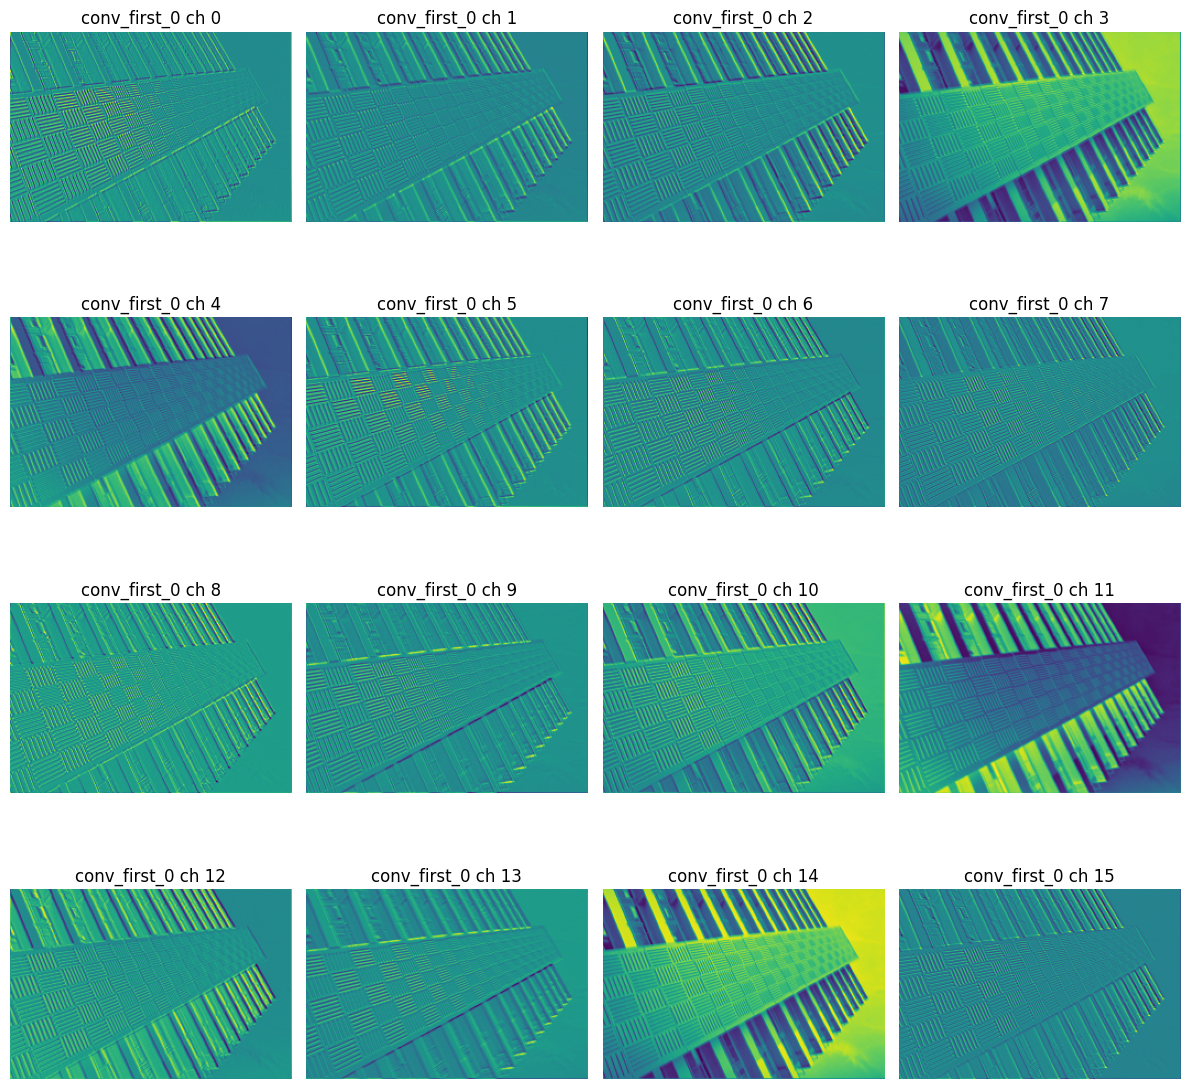

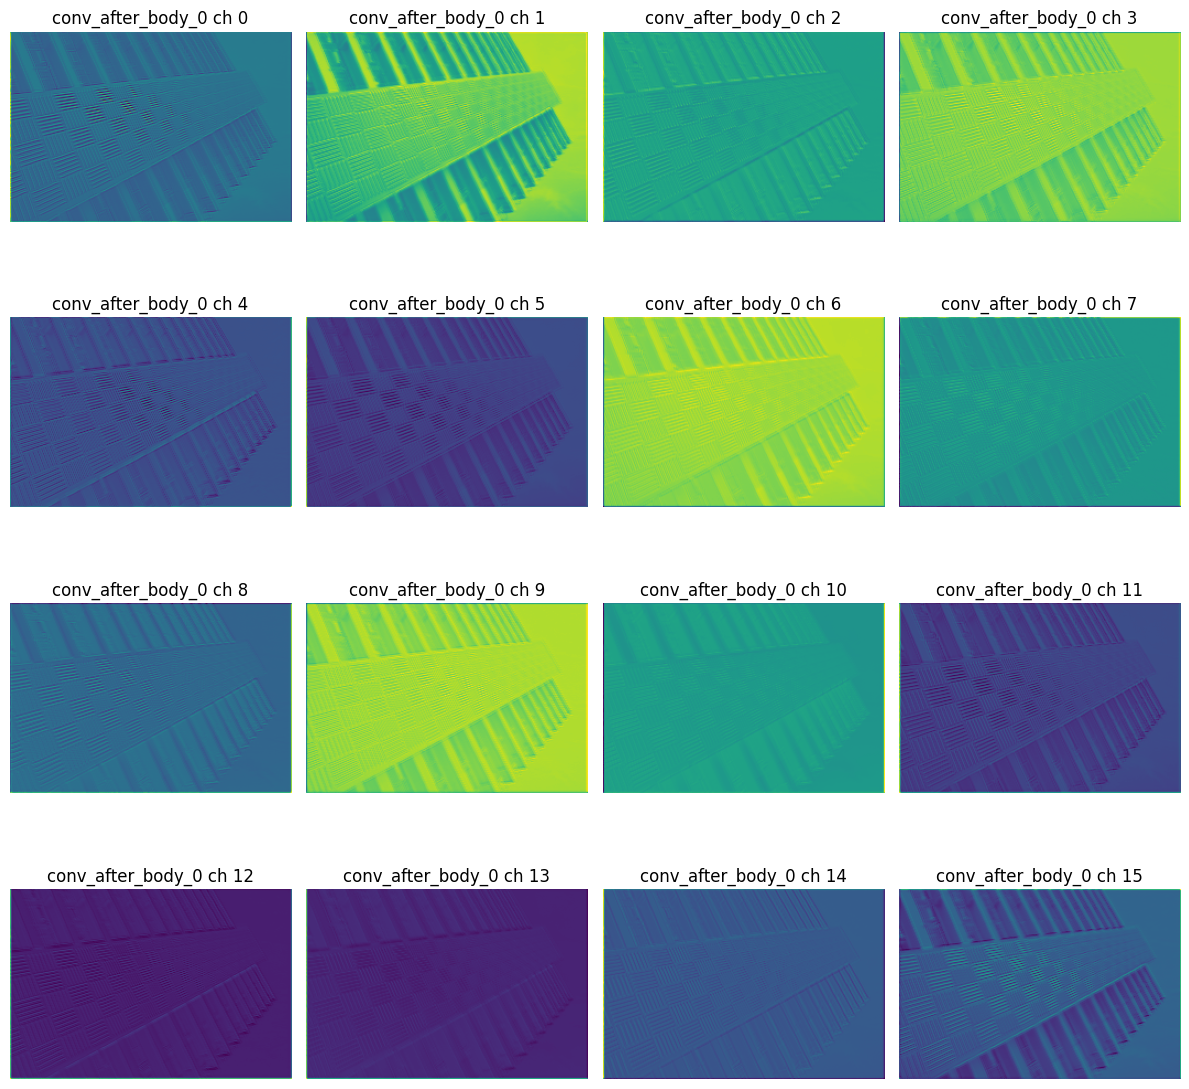

In [28]:
import torch
import yaml
import math
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as T
from arch.rwkv6srlite2 import RWKVIR

device = "cuda"

# ---------- load image ----------
img = read_image("training_data/test.png")
img = T.ConvertImageDtype(torch.float32)(img).unsqueeze(0).to(device)  # (1, C, H, W)

# ---------- load config ----------
config_path = "train_yamls/RWKV6SR_2X.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

model_config = config["model"]
depths = [model_config["blocks_per_layer"]] * model_config["residual_groups"]

# ---------- build model ----------
model = RWKVIR(
    img_size=model_config["patch_size"],
    depths=depths,
    hidden_rate=model_config["hidden_rate"],
    patch_size=model_config["patch_size"],
    img_range=1,
    embed_dim=model_config["embed_dim"],
    upscale=model_config["scale"],
    n_head=model_config["num_heads"],
    with_cp=model_config["with_cp"],
).to(device)

# ---------- load weights ----------
model_file = torch.load(
    "checkpoints/2X_RWKV6_9SR_longertrain2/iteration_5000.pt",
    map_location="cpu",
)
state_dict = model_file["model_state_dict"]
model.load_state_dict(state_dict)
model.eval()

# ---------- hook setup ----------
features = {}

def get_activation(name):
    def hook(module, input, output):
        # store on CPU to avoid GPU memory bloat
        features[name] = output.detach().cpu()
    return hook


conv_after_body = model.conv_after_body[4]
conv_after_body.register_forward_hook(get_activation("conv_after_body_0"))

conv_first = model.conv_first
conv_first.register_forward_hook(get_activation("conv_first_0"))

# layer_2_input = model.layers[2].conv1
# layer_2_input.register_forward_hook(get_activation("layer_2_input"))

# layer_2_output = model.layers[2].esa
# layer_2_output.register_forward_hook(get_activation("layer_2_output"))

with torch.no_grad():
    _ = model(img)

# ---------- visualization ----------
def show_feature_maps(activation, num_maps=8, title_prefix=""):
    if activation.dim() == 4:
        activation = activation[0]  # (C, H, W)

    C, H, W = activation.shape
    num_maps = min(num_maps, C)
    cols = 4
    rows = math.ceil(num_maps / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    for i in range(num_maps):
        fmap = activation[i]
        mn, mx = fmap.min(), fmap.max()
        if mx > mn:
            fmap = (fmap - mn) / (mx - mn)
        axes[i].imshow(fmap, cmap="viridis")
        axes[i].axis("off")
        axes[i].set_title(f"{title_prefix} ch {i}")

    for j in range(num_maps, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# show_feature_maps(features["layer_2_input"], num_maps=16, title_prefix="layer_2_input")
# show_feature_maps(features["layer_2_output"], num_maps=16, title_prefix="layer_2_output")

show_feature_maps(features["conv_first_0"], num_maps=16, title_prefix="conv_first_0")
show_feature_maps(features["conv_after_body_0"], num_maps=16, title_prefix="conv_after_body_0")